In [1]:
# Configure to use JAX internally
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
from qiskit_dynamics.array import Array

import jax.numpy as jnp
from jax import block_until_ready, vmap

/Users/arthurstrauss/opt/anaconda3/envs/custom_dynamics/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
import numpy as np

from qiskit import pulse, schedule
from qiskit_dynamics import Solver, DynamicsBackend, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit_dynamics.array import wrap
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, DensityMatrix
import sympy as sym

import matplotlib.pyplot as plt

jit = wrap(jax.jit, decorator=True)
qd_vmap = wrap(vmap, decorator=True)

# Build custom two qubit model

In [3]:
dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [4]:
# build solver
dt = 1 / 4.5e9
rtol = 1e-5
atol = 1e-3

t_linspace = np.linspace(0.0, 2.0 * 1e-6, 21)

dict_freqs = {"d0": v0, "d1": v1, "u0": v1, "u1": v0}
channels = {"d0", "d1", "u0", "u1"}

solver_sparse = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=channels,
    channel_carrier_freqs=dict_freqs,
    dt=dt,
    evaluation_mode="sparse",
)

solver_dense = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=channels,
    channel_carrier_freqs=dict_freqs,
    dt=dt,
    evaluation_mode="dense",
)

In [5]:
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

In [6]:
y0 = Array(Statevector(np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0])))


# y0 = full_ident


def sim_func_sparse(amp):
    _t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
    _center = _duration / 2

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * lifted_gaussian(_t, _center, _duration + 1, _sigma)
    )

    gaussian_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=0,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    # build a pulse schedule
    with pulse.build(default_alignment="sequential") as schedule:
        pulse.play(gaussian_pulse, pulse.DriveChannel(0))
        pulse.play(gaussian_pulse, pulse.DriveChannel(1))
        pulse.play(gaussian_pulse, pulse.ControlChannel(0))

    # convert from a pulse schedule to a list of signals
    converter = InstructionToSignals(dt, carriers=dict_freqs, channels=channels)

    signals = converter.get_signals(schedule)

    results = solver_sparse.solve(
        t_span=[t_linspace[0], t_linspace[-1]],
        y0=y0,
        signals=signals,
        t_eval=t_linspace,
        method="jax_odeint",
        atol=atol,
        rtol=rtol,
    )

    return results.y


def sim_func_dense(amp):
    _t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
    _center = _duration / 2

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * lifted_gaussian(_t, _center, _duration + 1, _sigma)
    )

    gaussian_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=0,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    # build a pulse schedule
    with pulse.build(default_alignment="sequential") as schedule:
        pulse.play(gaussian_pulse, pulse.DriveChannel(0))
        pulse.play(gaussian_pulse, pulse.DriveChannel(1))
        pulse.play(gaussian_pulse, pulse.ControlChannel(0))

    # convert from a pulse schedule to a list of signals
    converter = InstructionToSignals(dt, carriers=dict_freqs, channels=channels)

    signals = converter.get_signals(schedule)

    results = solver_dense.solve(
        t_span=[t_linspace[0], t_linspace[-1]],
        y0=y0,
        signals=signals,
        t_eval=t_linspace,
        method="jax_odeint",
        atol=atol,
        rtol=rtol,
    )

    return results.y


fast_sim_func_sparse = jit(sim_func_sparse)
fast_sim_func_dense = jit(sim_func_dense)

In [7]:
%time fast_sim_func_sparse(0.4).block_until_ready()

CPU times: user 1.88 s, sys: 63.9 ms, total: 1.94 s
Wall time: 1.93 s


Array([[ 1.00000000e+00+0.j        , -6.25155151e-18+0.j        ,
        -2.33549217e-18+0.j        , -2.42686892e-16+0.j        ,
         1.00000000e+00+0.j        ,  3.81639165e-16+0.j        ,
        -1.60064184e-18+0.j        ,  1.00000000e+00+0.j        ,
         1.35525272e-18+0.j        ],
       [ 4.51172256e-01-0.82866377j, -1.37231664e-01-0.23457294j,
         4.73248688e-02+0.0811774j , -4.86293839e-01-0.01771726j,
        -4.81134033e-01-0.8815995j ,  1.27848188e-01+0.28045539j,
         2.23657601e-02+0.30398261j, -8.32708479e-01-0.65601599j,
         2.35847916e-01+0.26180919j],
       [ 3.70206678e-01-0.85969786j, -2.57320558e-01-0.10228881j,
         4.57942933e-02+0.1093538j , -6.28373539e-01-0.12383564j,
        -3.43463621e-01-0.81305864j,  1.22079563e-01+0.38631155j,
        -1.64060252e-01+0.26270011j, -7.47967354e-01-0.69623027j,
         2.73072437e-01+0.37145632j],
       [ 3.70206678e-01-0.85969786j, -2.57320558e-01-0.10228881j,
         4.57942933e-02+0.10

In [8]:
%time fast_sim_func_dense(0.4).block_until_ready()

CPU times: user 1.2 s, sys: 25.1 ms, total: 1.22 s
Wall time: 1.22 s


Array([[ 1.00000000e+00+0.j        , -6.25155151e-18+0.j        ,
        -2.33549217e-18+0.j        , -2.42686892e-16+0.j        ,
         1.00000000e+00+0.j        ,  3.81639165e-16+0.j        ,
        -1.60064184e-18+0.j        ,  1.00000000e+00+0.j        ,
         1.35525272e-18+0.j        ],
       [ 4.51172257e-01-0.82866377j, -1.37231661e-01-0.23457294j,
         4.73248692e-02+0.0811774j , -4.86293836e-01-0.01771727j,
        -4.81134033e-01-0.8815995j ,  1.27848192e-01+0.28045539j,
         2.23657613e-02+0.30398261j, -8.32708480e-01-0.65601599j,
         2.35847919e-01+0.26180919j],
       [ 3.70206679e-01-0.85969786j, -2.57320556e-01-0.10228881j,
         4.57942944e-02+0.1093538j , -6.28373537e-01-0.12383564j,
        -3.43463621e-01-0.81305864j,  1.22079569e-01+0.38631155j,
        -1.64060251e-01+0.26270011j, -7.47967355e-01-0.69623027j,
         2.73072443e-01+0.37145632j],
       [ 3.70206679e-01-0.85969786j, -2.57320556e-01-0.10228881j,
         4.57942944e-02+0.10

In [9]:
%timeit fast_sim_func_sparse(0.4).block_until_ready()

res = fast_sim_func_sparse(0.4)
print(res.shape)

batch_amps = jnp.linspace(0.0, 0.5, 300)


def for_batch(batch_amps, fast_sim_func):
    for a in batch_amps:
        _ = fast_sim_func(a)


%timeit for_batch(batch_amps, fast_sim_func_sparse)

102 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(21, 9)
20.4 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit fast_sim_func_dense(0.4).block_until_ready()

res = fast_sim_func_dense(0.4)
print(res.shape)

batch_amps = jnp.linspace(0.0, 0.5, 300)


def for_batch(batch_amps, fast_sim_func):
    for a in batch_amps:
        _ = fast_sim_func(a)


%timeit for_batch(batch_amps, fast_sim_func_dense)

9.32 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(21, 9)
1.87 s ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


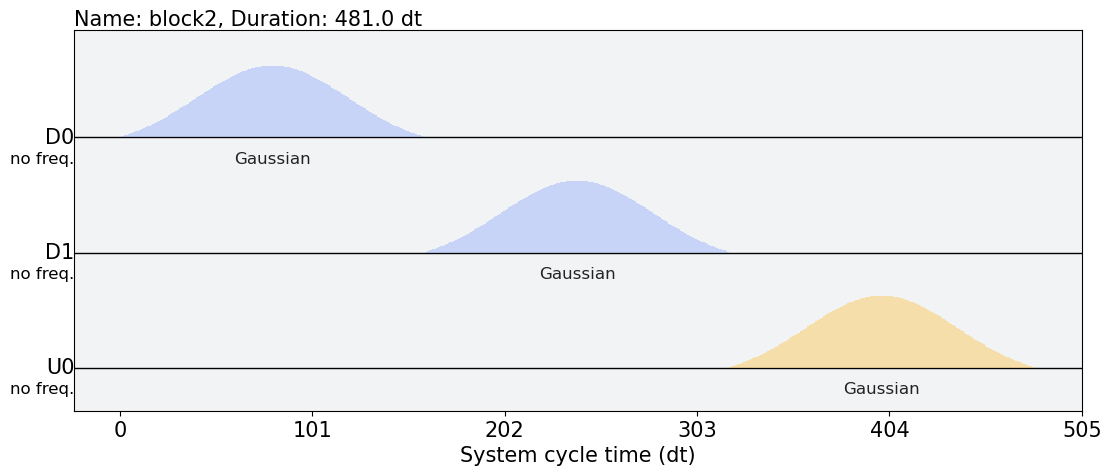

In [9]:
_t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
_center = _duration / 2

envelope_expr = (
    _amp * sym.exp(sym.I * _angle) * lifted_gaussian(_t, _center, _duration + 1, _sigma)
)

amp = Parameter("amp")

gaussian_pulse = pulse.ScalableSymbolicPulse(
    pulse_type="Gaussian",
    duration=160,
    amp=amp,
    angle=0,
    parameters={"sigma": 40},
    envelope=envelope_expr,
    constraints=_sigma > 0,
    valid_amp_conditions=sym.Abs(_amp) <= 1.0,
)

# build a pulse schedule
with pulse.build(default_alignment="sequential") as schedule:
    pulse.play(gaussian_pulse, pulse.DriveChannel(0))
    pulse.play(gaussian_pulse, pulse.DriveChannel(1))
    pulse.play(gaussian_pulse, pulse.ControlChannel(0))
    pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

schedule.assign_parameters({amp: 0.1}).draw()

In [12]:
batch_amps = np.linspace(0.0, 0.5, 300)
batch_circuits = [schedule.assign_parameters({amp: a}) for a in batch_amps]
%timeit batch_circuits =[schedule.assign_parameters({amp: a}) for a in batch_amps]
print(len(batch_circuits))

545 µs ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
300


In [10]:
# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": atol, "rtol": rtol, "hmax": dt}

initial_state = Statevector(np.array([1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]))
# initial_state = DensityMatrix(full_ident)

backend_sparse = DynamicsBackend(
    solver=solver_sparse,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
    initial_state=initial_state,
)
backend_dense = DynamicsBackend(
    solver=solver_dense,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
    initial_state=initial_state,
)

In [14]:
# Timing for the full run
%time job = backend_sparse.run(batch_circuits, shots=100)

CPU times: user 46.4 s, sys: 87.1 ms, total: 46.5 s
Wall time: 47.1 s


In [11]:
# Timing for the passage without the solving (just compilation)
%time job = backend_sparse.run(batch_circuits, shots=100)

CPU times: user 88.8 ms, sys: 4.02 ms, total: 92.8 ms
Wall time: 95.1 ms


In [13]:
# Timing for the passage without the solving (compilation -w/o sim -w sched to sample conv)
%time job = backend_sparse.run(batch_circuits, shots=100)

QiskitError: 'Invalid input: not a vector or column-vector.'

In [15]:
# Timing for the full run
%timeit job = backend_sparse.run(batch_circuits, shots=100)

45.6 s ± 255 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Timing for the passage without the solving (just compilation)
%timeit job = backend_sparse.run(batch_circuits, shots=100)

72.9 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# Timing for the passage without the solving (compilation -w/o sim -w sched to sample conv)
%timeit job = backend_sparse.run(batch_circuits, shots=100)

72.9 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%time job = backend_dense.run(batch_circuits, shots=100)

CPU times: user 20.9 s, sys: 28 ms, total: 20.9 s
Wall time: 21.2 s


In [17]:
%timeit job = backend_dense.run(batch_circuits, shots=100)

20.4 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit job = backend_dense.run(batch_circuits, shots=100)

68.6 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1]:
from qiskit.pulse import Schedule, Play
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider.local_service import BackendEstimatorV2

backend = GenericBackendV2(2)
qc = QuantumCircuit(2)
param = Parameter("phi")
param2 = Parameter("theta")
paramvec = ParameterVector("theta", 2)
qc.rx(paramvec[0], 0)
qc.ry(paramvec[1], 1)
qc.cx(0, 1)

qc2 = QuantumCircuit(2)
qc2.rx(param, 0)
qc2.ry(param2, 1)
qc2.cx(0, 1)
qc2.x(0)
estimator = BackendEstimatorV2(backend=backend)
observables = [SparsePauliOp.from_list([("ZI", 1), ("XZ", 1)])]

job = estimator.run(
    [
        (qc, observables, [[0.1, 0.3], [0.2, 0.5]]),
        (qc2, observables, [[0.1, 0.3], [0.2, 0.5]]),
    ]
)
result = job.result()
ev = result[0].data

DataBin<3>(evs=[-0.00976562  0.01074219  0.00048828], stds=[0.01562425 0.0156241  0.015625  ])

In [6]:
import jax
import jax.numpy as jnp

# Define a dictionary with integer keys
dict = {0: "zero", 1: "one", 2: "two"}


# Define a function that uses a traced integer to access the dictionary
def func(x):
    x_rounded = jnp.round(x).astype(int)
    return jax.lax.switch(
        x_rounded, [lambda _: v for v in dict.values()], lambda _: "default"
    )


# JIT compile the function
jit_func = jax.jit(func)

# Call the JIT compiled function
print(jit_func(1.9))  # Outputs: 'two'

TypeError: Value <function func.<locals>.<lambda> at 0x33dfdff60> with type <class 'function'> is not a valid JAX type